In [8]:
# Run this to install tensorflow version 1.9
# !pip install tensorflow==1.9

In [9]:
import gym
import random
import numpy as np
import tensorflow as tf
from collections import deque
print("Gym:", gym.__version__)
print("Tensorflow:", tf.__version__)

Gym: 0.10.11
Tensorflow: 1.9.0


In [11]:
class QNetwork():
    def __init__(self, state_dim, action_size, tau=0.01):
        tf.reset_default_graph()
        self.state_in = tf.placeholder(tf.float32, shape=[None, *state_dim])
        self.action_in = tf.placeholder(tf.int32, shape=[None])
        self.q_target_in = tf.placeholder(tf.float32, shape=[None])
        self.importance_in = tf.placeholder(tf.float32, shape=[None])
        action_one_hot = tf.one_hot(self.action_in, depth=action_size)
        
        self.q_state_local = self.build_model(action_size, "local")
        self.q_state_target = self.build_model(action_size, "target")
        
        self.q_state_action = tf.reduce_sum(tf.multiply(self.q_state_local, action_one_hot), axis=1)
        self.error = self.q_state_action - self.q_target_in
        self.loss = tf.reduce_mean(tf.multiply(tf.square(self.error), self.importance_in))
        self.optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(self.loss)
        
        self.local_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="local")
        self.target_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="target")
        self.updater = tf.group([tf.assign(t, t + tau*(l-t)) for t,l in zip(self.target_vars, self.local_vars)])
        
    def build_model(self, action_size, scope):
        with tf.variable_scope(scope):
            hidden1 = tf.layers.dense(self.state_in, 100, activation=tf.nn.relu)
            q_state = tf.layers.dense(hidden1, action_size, activation=None)
            return q_state
        
    def update_model(self, session, state, action, q_target, importance):
        feed = {self.state_in: state, self.action_in: action, self.q_target_in: q_target, self.importance_in: importance}
        error, _, _ = session.run([self.error, self.optimizer, self.updater], feed_dict=feed)
        return error
        
    def get_q_state(self, session, state, use_target=False):
        q_state_op = self.q_state_target if use_target else self.q_state_local
        q_state = session.run(q_state_op, feed_dict={self.state_in: state})
        return q_state

In [12]:
class PrioritizedReplayBuffer():
    def __init__(self, maxlen):
        self.buffer = deque(maxlen=maxlen)
        self.priorities = deque(maxlen=maxlen)
        
    def add(self, experience):
        self.buffer.append(experience)
        self.priorities.append(max(self.priorities, default=1))
        
    def get_probabilities(self, priority_scale):
        scaled_priorities = np.array(self.priorities) ** priority_scale
        sample_probabilities = scaled_priorities / sum(scaled_priorities)
        return sample_probabilities
    
    def get_importance(self, probabilities):
        importance = 1/len(self.buffer) * 1/probabilities
        importance_normalized = importance / max(importance)
        return importance_normalized
        
    def sample(self, batch_size, priority_scale=1.0):
        sample_size = min(len(self.buffer), batch_size)
        sample_probs = self.get_probabilities(priority_scale)
        sample_indices = random.choices(range(len(self.buffer)), k=sample_size, weights=sample_probs)
        samples = np.array(self.buffer)[sample_indices]
        importance = self.get_importance(sample_probs[sample_indices])
        return map(list, zip(*samples)), importance, sample_indices
    
    def set_priorities(self, indices, errors, offset=0.1):
        for i,e in zip(indices, errors):
            self.priorities[i] = abs(e) + offset

In [14]:
class DoubleDQNAgent():
    def __init__(self, env):
        self.state_dim = env.observation_space.shape
        self.action_size = env.action_space.n
        self.q_network = QNetwork(self.state_dim, self.action_size)
        self.replay_buffer = PrioritizedReplayBuffer(maxlen=100000)
        self.gamma = 0.97
        self.eps = 1.0
        
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
        
    def get_action(self, state):
        q_state = self.q_network.get_q_state(self.sess, [state])
        action_greedy = np.argmax(q_state)
        action_random = np.random.randint(self.action_size)
        action = action_random if random.random() < self.eps else action_greedy
        return action
    
    def get_env_action(self, action):
        return action
    
    def train(self, state, action, next_state, reward, done, use_DDQN=True, a=0.0):
        self.replay_buffer.add((state, action, next_state, reward, done))
        (states, actions, next_states, rewards, dones), importance, indices = self.replay_buffer.sample(50, priority_scale=a)
        
        next_actions = np.argmax(self.q_network.get_q_state(self.sess, next_states, use_target=False), axis=1)
        q_next_states = self.q_network.get_q_state(self.sess, next_states, use_target=use_DDQN)
        q_next_states[dones] = np.zeros([self.action_size])
        q_next_states_next_actions = q_next_states[np.arange(next_actions.shape[0]), next_actions]
        q_targets = rewards + self.gamma * q_next_states_next_actions
        errors = self.q_network.update_model(self.sess, states, actions, q_targets, importance**(1-self.eps))
        
        self.replay_buffer.set_priorities(indices, errors)
        
        if done: self.eps = max(0.1, 0.98*self.eps)
    
    def __del__(self):
        self.sess.close()

In [22]:
class DiscretizedDQNAgent(DoubleDQNAgent):
    def __init__(self, env, n_actions=10):
        self.is_discrete = type(env.action_space) == gym.spaces.discrete.Discrete
        if not self.is_discrete:
            env.action_space.n = n_actions
            self.actions = np.linspace(env.action_space.low, env.action_space.high, n_actions)
        super().__init__(env)
        
    def get_env_action(self, action):
        if not self.is_discrete:
            action = [self.actions[action]]
        return action

In [30]:
env_names = ["CartPole-v0",
             "MountainCar-v0",
             "MountainCarContinuous-v0",
             "Pendulum-v0",
             "Acrobot-v1"]
env = gym.make(env_names[4])
print("Observation space:", env.observation_space)
print("Action space:", env.action_space)

Observation space: Box(6,)
Action space: Discrete(3)


In [33]:
num_runs = 1
run_rewards = []

for n in range(num_runs):
    print("Run {}".format(n))
    ep_rewards = []
    agent = None
    agent = DiscretizedDQNAgent(env)
    num_episodes = 100

    for ep in range(num_episodes):
        state = env.reset()
        total_reward = 0
        done = False
        while not done:
            action = agent.get_action(state)
            next_state, reward, done, info = env.step(agent.get_env_action(action))
            agent.train(state, action, next_state, reward, done, a=0.7)
            env.render()
            total_reward += reward
            state = next_state

        ep_rewards.append(total_reward)
        print("Episode: {}, total_reward: {:.2f}".format(ep, total_reward))
        
    run_rewards.append(ep_rewards)

Run 0
Episode: 0, total_reward: -500.00
Episode: 1, total_reward: -500.00
Episode: 2, total_reward: -500.00
Episode: 3, total_reward: -500.00
Episode: 4, total_reward: -500.00
Episode: 5, total_reward: -500.00
Episode: 6, total_reward: -472.00
Episode: 7, total_reward: -500.00
Episode: 8, total_reward: -500.00
Episode: 9, total_reward: -500.00
Episode: 10, total_reward: -500.00
Episode: 11, total_reward: -500.00
Episode: 12, total_reward: -446.00
Episode: 13, total_reward: -500.00
Episode: 14, total_reward: -500.00
Episode: 15, total_reward: -367.00
Episode: 16, total_reward: -500.00
Episode: 17, total_reward: -469.00
Episode: 18, total_reward: -434.00
Episode: 19, total_reward: -500.00
Episode: 20, total_reward: -500.00
Episode: 21, total_reward: -500.00
Episode: 22, total_reward: -322.00
Episode: 23, total_reward: -171.00
Episode: 24, total_reward: -294.00
Episode: 25, total_reward: -308.00
Episode: 26, total_reward: -322.00
Episode: 27, total_reward: -384.00
Episode: 28, total_rewar

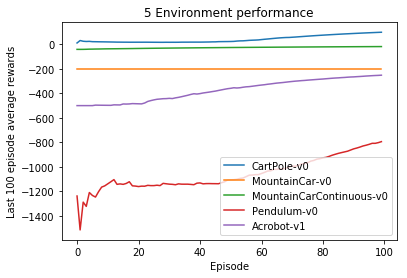

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline

for n, ep_rewards in enumerate(run_rewards):
    x = range(len(ep_rewards))
    cumsum = np.cumsum(ep_rewards)
    avgs = [cumsum[ep]/(ep+1) if ep<100 else (cumsum[ep]-cumsum[ep-100])/100 for ep in x]
    plt.plot(x, avgs, label=env_names[n])
    
plt.title("5 Environment performance")
plt.xlabel("Episode")
plt.ylabel("Last 100 episode average rewards")
plt.legend()

In [32]:
env.close()